# 📊 Federated Learning Log Analysis

This notebook is used to analyze the results of Federated Learning (FL) training for each client based on RMSE logs per round.

## ✅ Analysis Goals
- Visualize RMSE trends for each client over training rounds
- Identify the *ideal round* (when model performance stabilizes)
- Extract insights on the performance of the FL model

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt


## 🔍 RMSE Analysis Function

The following function reads each client's RMSE log file, calculates the downward trend using a moving average of round-to-round differences, then displays a plot and automatically determines the ideal round based on RMSE stability.

In [67]:
def analyze_log_plot(path, client_name, plot=True):
    df = pd.read_csv(path)
    df["round"] = pd.to_numeric(df["round"], errors="coerce")
    df.dropna(inplace=True)
    
    # Hitung slope (delta) dan moving average-nya
    df["delta_rmse"] = df["rmse"].diff().fillna(0)
    df["slope_ma"] = df["delta_rmse"].rolling(window=3).mean()

    # Heuristik: round ideal saat slope rata-rata < threshold
    threshold = 3.0
    stagnation = None
    for i in range(len(df)):
        if abs(df["slope_ma"].iloc[i]) < threshold:
            stagnation = int(df["round"].iloc[i])
            break

    print(f"✅ {client_name} - Ideal round ≈ {stagnation or 'Not Found'}")

    # Plot RMSE
    if plot:
        plt.figure(figsize=(8,5))
        plt.plot(df["round"], df["rmse"], marker='o', label=f"{client_name}")
        if stagnation:
            plt.axvline(stagnation, color="red", linestyle="--", label="Ideal Round")
        plt.xlabel("Round")
        plt.ylabel("RMSE")
        plt.title(f"RMSE vs Round - {client_name}")
        plt.grid(True)
        plt.legend()
        plt.show()

def summarize_logs(log_dir="../logs", threshold=3.0, window=3):
    summary = []

    for file in os.listdir(log_dir):
        if file.endswith("_fedlog.csv"):
            path = os.path.join(log_dir, file)
            client_name = file.replace("_fedlog.csv", "")
            df = pd.read_csv(path)
            df["round"] = pd.to_numeric(df["round"], errors="coerce")
            df.dropna(inplace=True)

            df["delta_rmse"] = df["rmse"].diff().fillna(0)
            df["slope_ma"] = df["delta_rmse"].rolling(window=window).mean()

            stagnation = None
            for i in range(len(df)):
                if abs(df["slope_ma"].iloc[i]) < threshold:
                    stagnation = int(df["round"].iloc[i])
                    break

            summary.append({
                "client": client_name,
                "final_rmse": float(df["rmse"].iloc[-1]),
                "ideal_round": stagnation or "Not Found"
            })

    summary_df = pd.DataFrame(summary).sort_values(by="client")
    print("✅ Summary ideal round per client:")
    display(summary_df)
    return summary_df

## 📁 Load All Client Logs

This section searches for all `*_fedlog.csv` files in the `../logs` folder and runs the analysis for each client individually.

✅ client_1 - Ideal round ≈ 8


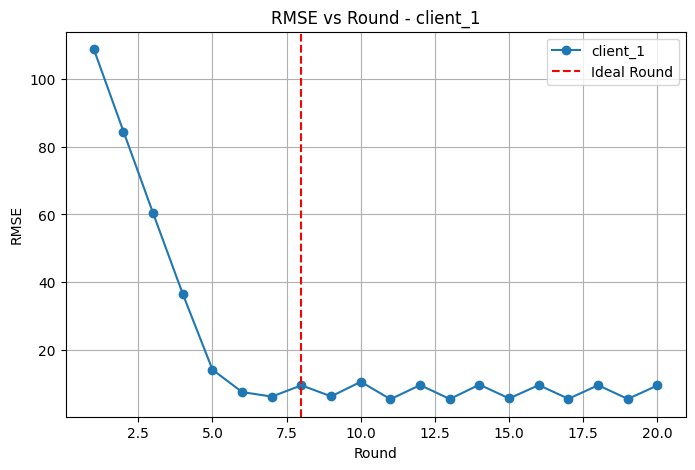

✅ client_2 - Ideal round ≈ 9


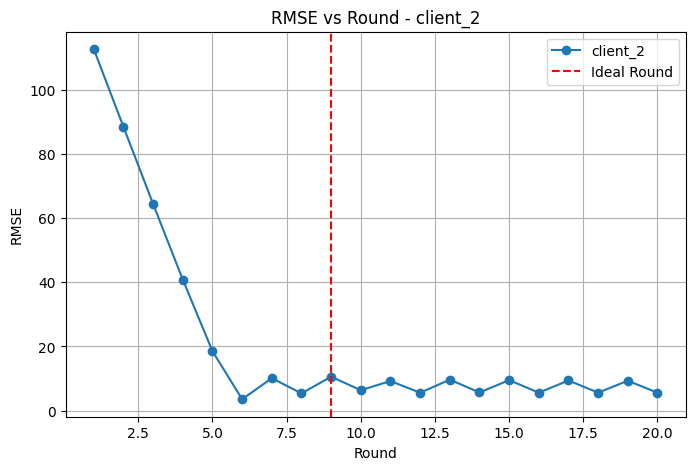

✅ client_3 - Ideal round ≈ 8


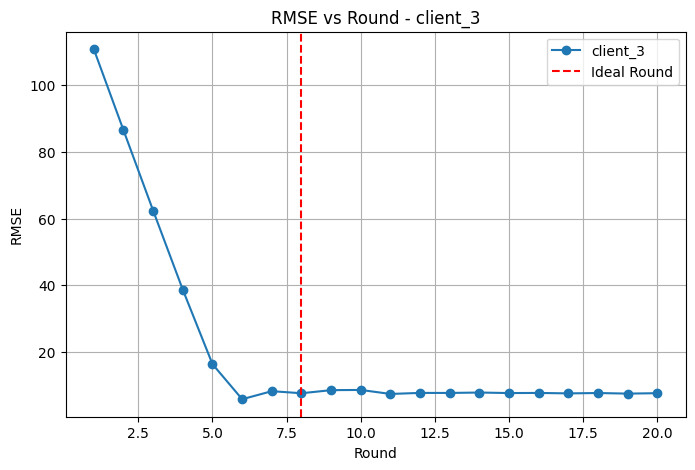

✅ Summary ideal round per client:


,client,final_rmse,ideal_round
0,client_1,9.566339,8
1,client_2,5.558473,9
2,client_3,7.716372,8


In [68]:
log_dir = "../logs"
log_files = [f for f in os.listdir(log_dir) if f.endswith("_fedlog.csv")]

# Buat grafik RMSE per client
for file in log_files:
    path = os.path.join(log_dir, file)
    name = file.replace("_fedlog.csv", "")
    analyze_log_plot(path, name)

# Tampilkan tabel summary round ideal semua client
summary_df = summarize_logs(log_dir="../logs")

In [70]:
most_stable = summary_df.loc[summary_df["final_rmse"].idxmin()]
print(f"✅ Most stable client: {most_stable['client']} (Final RMSE: {most_stable['final_rmse']:.2f})")

summary_df_clean = summary_df[summary_df["ideal_round"] != "Not Found"]
avg_ideal = summary_df_clean["ideal_round"].astype(int).mean()
print(f"📊 Average ideal round: {avg_ideal:.2f}")

✅ Most stable client: client_2 (Final RMSE: 5.56)
📊 Average ideal round: 8.33


## 🧠 Preliminary Insights

- The most stable client is **Client 2**, with a final RMSE of **5.56**
- The average ideal round across clients is **8.33**

### 🔜 Next Steps
- Compare results with the **centralized baseline**
- Run experiments under **non-IID data distribution**